In [1]:
# Generic imports
from pathlib import Path
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
import scipy.stats 

%matplotlib inline

from SAR_retrieval_funcs import cost_function, fwd_model
from SAR_retrieval_funcs import invert_field, do_plots, prepare_field_data



In [2]:
chunk = """;301;301;301;301;301;301;301;301;301;301;301;301;508;508;508;508;508;508;508;508;508;508;508;508;542;542;542;542;542;542;542;542;542;542;542;542;319;319;319;319;319;319;319;319;319;319;319;319;515;515;515;515;515;515;515;515;515;515;515;515
;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv
"""
fields = chunk.split("\n")[0].split(";")[1:]
col_names = [f"{col:s}_{fields[i]:s}" for i,
             col in enumerate(chunk.split("\n")[1].split(";")[1:])]

df = pd.read_csv("multi.csv", skiprows=2, sep=";", names=col_names)
fields = ["301", "508", "542", "319", "515"]

for field in fields:
    df[f"doy_{field:s}"] = pd.to_datetime(df[f'date_{field:s}']).dt.dayofyear

(0, 1)

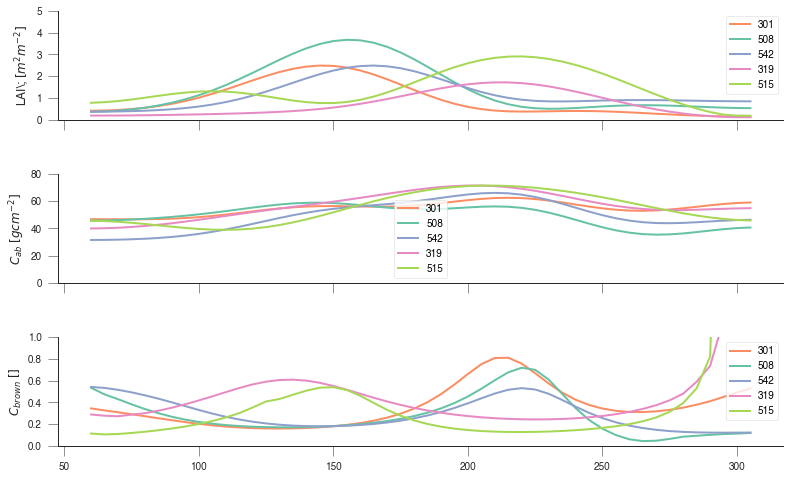

In [3]:
df_s2 = pd.read_csv("LMU_S2_field_retrievals.csv", sep=";")
df_s2['doy'] = pd.to_datetime(df_s2.dates).dt.dayofyear
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True,
                        squeeze=True, figsize=(13, 8))
l1 = []
l2 = []
l3 = []
for field in fields:
    l1.append(axs[0].plot(df_s2.doy, df_s2[f"lai_{field:s}"],
                          label=field))
    l2.append(axs[1].plot(df_s2.doy, df_s2[f"cab_{field:s}"],
                          label=field))
    l3.append(axs[2].plot(df_s2.doy, df_s2[f"cbrown_{field:s}"],
                          label=field))

axs[0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
axs[1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")
axs[2].legend([l[0] for l in l3], [l[0].get_label() for l in l3], loc="best")


axs[0].set_ylabel(r"LAI\; $[m^{2}m^{-2}]$")
axs[1].set_ylabel(r"$C_{ab}\;[gcm^{-2}]$")
axs[2].set_ylabel(r"$C_{brown}\;[]$")
axs[0].set_ylim(0, 5)
axs[1].set_ylim(0, 80)
axs[2].set_ylim(0, 1)

In [6]:
field = "508"
doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(
    field, df, df_s2)


/home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [47]:
def modified_dubois(delta, beta, gamma, eps,
                    rough, mv, theta):
    sigma = np.log10(delta*np.cos(theta)**beta)
    sigma += gamma*mv/np.tan(theta)
    sigma += np.log10(rough**(eps*np.sin(theta)))
    return 10*sigma

def modified_dubois_vv(rough, mv, theta):
    delta = 10**(-1.138)
    beta = 1.528
    gamma = 1. # 0.009
    eps = 0.71
    sigma = modified_dubois(delta, beta, gamma,
                            eps, rough, mv, theta)
    return sigma

def modified_dubois_vh(rough, mv, theta):
    delta = 10**(-2.325)
    beta = -0.01
    gamma = 1. # 0.011
    eps = 0.44
    sigma = modified_dubois(delta, beta, gamma,
                            eps, rough, mv, theta)
    return sigma

def cost_smooth(x, gamma):
    """A smoother for one parameter (e.g. LAI or whatever).
    `gamma` controls the magnitude of the smoothing (higher
    `gamma`, more smoothing)
    """
    # Calculate differences
    p_diff1 = x[1:-1] - x[2:]
    p_diff2 = x[1:-1] - x[:-2]
    # Cost function
    xcost_model = 0.5 * gamma * np.sum(p_diff1 ** 2 + p_diff2 ** 2)
    # Jacobian
    xdcost_model = 1 * gamma * (p_diff1 + p_diff2)
    # Note that we miss the first and last elements of the Jacobian
    # They're zero!
    return xcost_model, xdcost_model


def cost(x, svv, svh, theta, passer, gamma_rough=1, unc=0.5, fwd=False):
    svv = svv.values[passer]
    svh = svh.values[passer]
    
    theta = np.deg2rad(theta.values[passer])
    n_obs = len(svv)
    mv = x[:n_obs]
    rough = x[n_obs:]
    fwd_svv = modified_dubois_vv(rough, mv, theta)
    fwd_svh = modified_dubois_vh(rough, mv, theta)
    
    diff_vv = fwd_svv - svv
    diff_vh = fwd_svh - svh
    cost = 0.5*(diff_vv**2 + diff_vh**2)/unc**2
    cost_rough, dcost_rough = cost_smooth(rough, gamma_rough)
    #jac = diff_vv*d_svv + diff_vh*d_svh
    if fwd:
        return cost.sum() + cost_rough.sum(), fwd_svv, fwd_svh
    else:
        return cost.sum() + cost_rough.sum()#, jac


passer = s2_lai > 0
    
n_obs = np.sum(passer)
#bounds = [[None, None],]*2 + [[0.01, 0.5],]*n_obs
x0 = np.concatenate([np.ones(n_obs)*0.2, 4*np.ones(n_obs)])
retval = scipy.optimize.minimize(cost, x0, jac=False, args=(svv, svh, theta, passer,1e3),
                                 method="L-BFGS-B",
                                options={"disp": True})#,bounds = bounds)
    


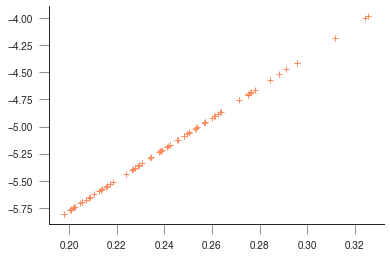

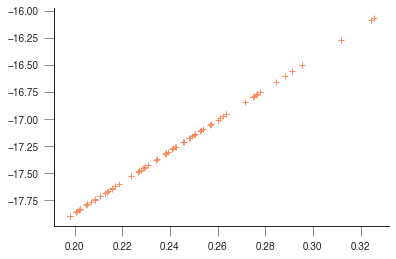

In [48]:
x = df[f"doy_{field:s}"].values
sm_f = df[f"SM_{field:s}"].values
plt.figure()
plt.plot(sm_f, modified_dubois_vv(10., sm_f, np.deg2rad(35.)), '+')
plt.figure()
plt.plot(sm_f, modified_dubois_vh(10., sm_f, np.deg2rad(35.)), '+')

299077.32580831996
2676.5616398477873
[-1.7622753  -1.74414767 -0.89895581 -1.28300065]


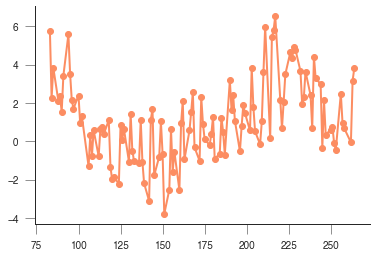

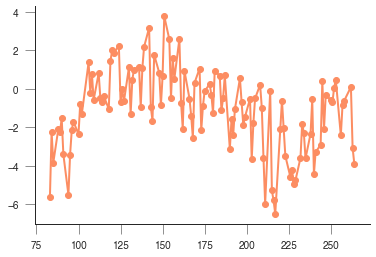

In [49]:
print(cost(x0, svv, svh, theta, passer))
print(cost(retval.x, svv, svh, theta, passer))

c, fwd_svv, fwd_svh = cost(retval.x, svv, svh, theta, passer, fwd=True)
plt.plot(doy[passer], svv[passer] - fwd_svv, '-o')
plt.figure()
plt.plot(doy[passer], svh[passer] - fwd_svh, '-o')
#plt.semilogy(doy[passer], svh[passer] - fwd_svh, '-o')
print(retval.x[:4])
# plt.plot(doy[passer], fwd_svv, '-')
# plt.plot(doy[passer], fwd_svh, '-')

No handles with labels found to put in legend.


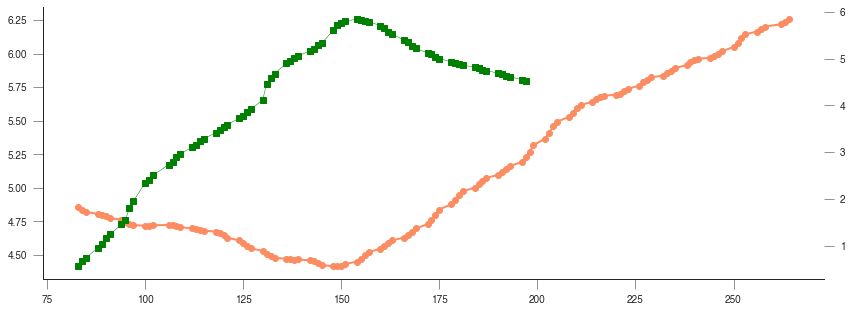

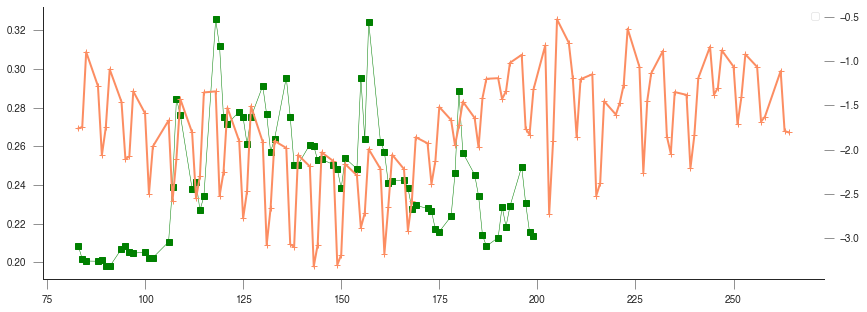

In [57]:
plt.figure(figsize=(14,5))
plt.plot(doy[passer], retval.x[n_obs:], "-o")
plt.twinx()
plt.plot(
        df[f"doy_{field:s}"], df[f"LAI_{field:s}"], "s-g", lw=0.5, label="Sigma SM"
    )
plt.figure(figsize=(14,5))
plt.plot(
        df[f"doy_{field:s}"], df[f"SM_{field:s}"], "s-g", lw=0.5, label="Sigma SM"
    )
plt.twinx()
plt.plot(doy[passer], retval.x[:n_obs], "-+")
plt.legend()

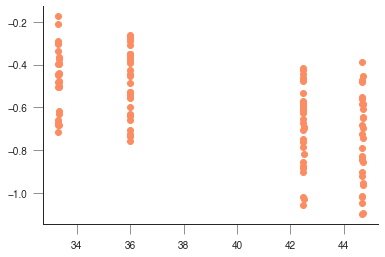

In [46]:
plt.plot(theta, retval.x[:n_obs], 'o')